In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import svds
import networkx as nx
from copy import deepcopy
from scipy import linalg

# Graphs

Deals with basic graphs. There are two examples, the les mis and harry potter networks. 

In [ ]:
# replace with own path to data folder:
path = 'path_to_data_folder'

# Functions

In [3]:
def make_adjacency_matrix(n, source, target, weight = None):
    """ 
    Make adjacency matrix from source and target arrays.    
    """ 

    if weight is None:
        weights = np.ones(len(n))
    else:
        weights = weight
    A1 = sparse.coo_matrix((weights, (source, target)), shape=(n,n))
    A2 = sparse.coo_matrix((weights, (target, source)), shape=(n,n))
    return A1 + A2

In [4]:
def degree_correction(X):
    """
    Perform degree correction.
    """
    tol = 1e-12
    Y = deepcopy(X)
    norms = np.linalg.norm(X, axis=1)
    idx = np.where(norms > tol)
    Y[idx] = X[idx] / (norms[idx, None])
    return Y

In [5]:
def embed(A, d = 10):
    """ 
    Embed a graph using adjacency matrix.   
    """
    A = A.astype(float)
    u, s, vT = svds(A, d)
    o = np.argsort(s[::-1])
    embedding = u[:,o] @ np.diag(np.sqrt(s[o]))                  
    return embedding

In [77]:
# find intersection of two lists    
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# find union of two lists   
def union(list1, list2):    
    final_list = list(list1) + list(list2)    
    return final_list


In [103]:
def safe_inv_sqrt(a, tol=1e-12):
    """
    Compute the inverse square root of an array, ignoring division by zero.
    """
    with np.errstate(divide="ignore"):
        b = 1 / np.sqrt(a)
    b[np.isinf(b)] = 0
    b[a < tol] = 0
    return b

def to_laplacian(A, regulariser=0):
    """
    Convert an adjacency matrix to a Laplacian matrix.

    Parameters
    ----------
    A : scipy.sparse.csr_matrix
        The adjacency matrix.
    regulariser : float
        The regulariser to be added to the degrees of the nodes.

    Returns
    -------
    L : scipy.sparse.csr_matrix
        The Laplacian matrix.
    """

    left_degrees = np.reshape(np.asarray(A.sum(axis=1)), (-1,))
    right_degrees = np.reshape(np.asarray(A.sum(axis=0)), (-1,))
    if regulariser == 'auto':
        regulariser = np.mean(np.concatenate((left_degrees, right_degrees)))
    left_degrees_inv_sqrt = safe_inv_sqrt(left_degrees + regulariser)
    right_degrees_inv_sqrt = safe_inv_sqrt(right_degrees + regulariser)
    L = sparse.diags(left_degrees_inv_sqrt) @ A @ sparse.diags(right_degrees_inv_sqrt)
    return L

# Les Mis

Data .csv version from: https://networks.skewed.de/net/lesmis

The network of scene coappearances of characters in Victor Hugo's novel "Les Miserables". Edge weights denote the number of such occurrences.

In [6]:
edges = pd.read_csv(path + '/edges.csv')
nodes = np.array(pd.read_csv(path + '/nodes.csv')[' label'])

edges.columns = ['source', 'target','weight']

In [7]:
id_to_node = dict(zip(range(len(nodes)), nodes))
n = len(id_to_node)

In [8]:
A = make_adjacency_matrix(n, edges['source'], edges['target'], edges['weight'])
# A = A.todense()

In [9]:
# make networkx graph from source and target and weight 
G = nx.from_pandas_edgelist(edges, 'source', 'target', 'weight')

In [10]:
for key, value in id_to_node.items():
    G.nodes[key]['name'] = value

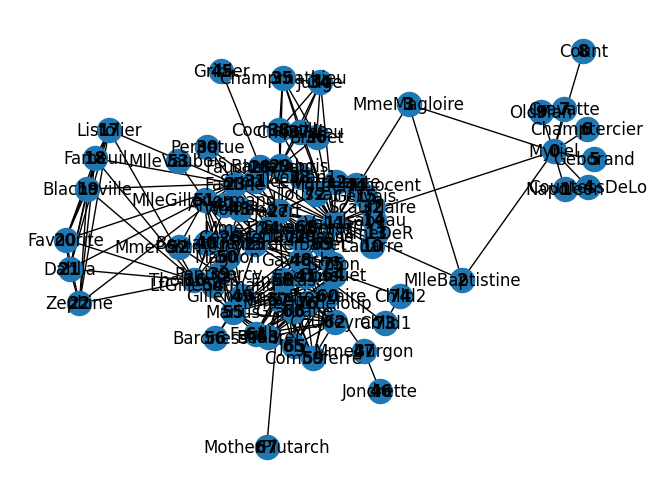

In [11]:
nx.draw(G, with_labels=True,pos=nx.kamada_kawai_layout(G), font_weight='bold')
nx.draw_networkx_labels(G,labels = id_to_node, pos=nx.kamada_kawai_layout(G));

In [12]:
# use plotly to plot the first two dimensions of embed with hovertext given by the names of the characters  
import plotly.graph_objects as go       
embedding = embed(A, d = 10)

embedding = degree_correction(embedding)

fig = go.Figure(data=go.Scatter(x=embedding[:,0],
                                y=embedding[:,1],
                                mode='markers+text',
                                hovertext = nodes,
                                textposition="bottom center"))  
fig.update_layout(title = 'Les Miserables Characters',  
                    xaxis_title = 'First Dimension', 
                    yaxis_title = 'Second Dimension', 
                    hovermode = 'closest',
                    width = 400,    
                    height = 400) 
fig.show()  


# HP

In [78]:
data = pd.read_csv(path + '/harry_potter.csv', sep = ',')
attributes = pd.read_csv(path + '/HP-characters.csv', sep=',')


In [83]:
# find unique elements of a list    
def unique(list1):  
    unique_list = []   
    for x in list1: 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list


In [85]:
present_ids =  sorted(unique(union(data['source'].unique(), data['target'].unique())))

In [87]:
attributes = attributes[attributes['id'].isin(present_ids)].reset_index(drop=True)

In [88]:
nodes = list(attributes['name'])
n = len(nodes)

In [90]:
id_to_node = dict(zip(range(len(nodes)), nodes))

In [91]:
# replace '-' on type column to -1  
data = data.replace('-', -1)

In [92]:
data = data.replace('+', 1)

In [93]:
A = make_adjacency_matrix(n, data['source'], data['target'], data['type'])

In [108]:
# use plotly to plot the first two dimensions of embed with hovertext given by the names of the characters  
import plotly.graph_objects as go       
embedding = embed(A, d = 10)
# embedding = to_laplacian(A,regulariser=1).todense()

# embedding = degree_correction(embedding)

fig = go.Figure(data=go.Scatter(x=embedding[:,0],
                                y=embedding[:,1],
                                mode='markers+text',
                                hovertext = nodes,
                                marker=dict(size=10),
                                textposition="bottom center"))  
fig.update_layout(title = 'Harry Potter Characters',  
                    xaxis_title = 'First Dimension', 
                    yaxis_title = 'Second Dimension', 
                    hovermode = 'closest',
                    width = 750,    
                    height = 750) 
fig.show()  
